Импорт необходимых библиотек и задание некоторых параметров отрисовки графиков по умолчанию

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tools.eval_measures import mse
from scipy.optimize import minimize

In [ ]:
plt.rcParams['font.size'] = 11
plt.rcParams['savefig.format'] = 'pdf'

Выгрузим исходный датасет с данными о кол-ве пассажиров по месяцам

In [ ]:
df = pd.read_csv('/content/11. Number of domestic air travel passengers.csv', index_col='Date', parse_dates=True)
# Преобразуем индекс и название колонки в более удобный формат
df.index = pd.DatetimeIndex(df.index, freq='MS')
df.rename(columns={"Number of domestic air passengers":"num_passengers"}, inplace=True)

df.head()

,num_passengers
Date,
2003-01-01,43032450
2003-02-01,41166780
2003-03-01,49992700
2003-04-01,47033260
2003-05-01,49152352


Визуализируем исходные данные, чтобы сделать первые предположения о наличии в данных ярко выраженных сезонности и тренда. Рядом выведем и коррелограмму для подкрепления вывода о возможной сезонности

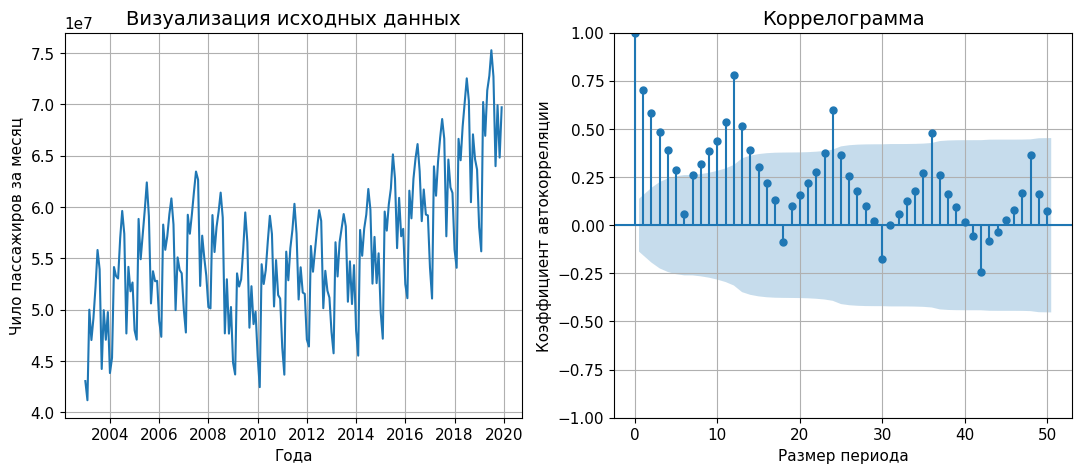

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(13,5))
ax[0].plot(df)
ax[0].set_title("Визуализация исходных данных", fontsize=14)
ax[0].set_xlabel("Года")
ax[0].set_ylabel("Чило пассажиров за месяц")
ax[0].grid()

plot_acf(df['num_passengers'], lags=50, ax=ax[1])
ax[1].set_title("Коррелограмма", fontsize=14)
ax[1].set_xlabel("Размер периода")
ax[1].set_ylabel("Коэффициент автокорреляции")
ax[1].grid()

plt.show()

Как можно заметить, ***в данных четко прослеживаются сезонные колебания в кол-ве пассажиров***: *пик сверху стабильно приходится примерно на середину года* (июнь-июль), *а пик снизу - на его начало*
(январь-февраль); ***коэффициент автокорреляции с периодом в 12 месяцев имеет значение порядка 0.8***, что больше чем у других потенциальных размеров периодов. Таким образом, **можем зафиксировать период сезонности в 12 месяцев**.

***Тренд на первом графике также явно прослеживается***, однако он скорее *похож на некоторый зигзаг*, чем на прямую линию. Отрисуем ниже разложение на тренд и сезонность для аддитивной и мультипликативной зависимостей

In [ ]:
m=12 # Зафиксируем сезонность

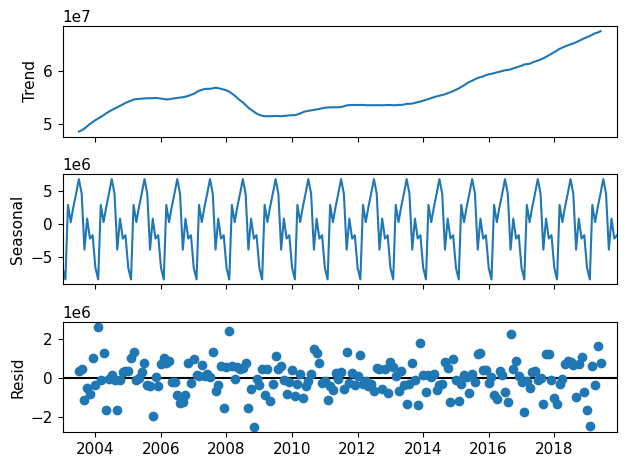

In [ ]:
additive_decomposition = seasonal_decompose(
    df['num_passengers'],
    model='additive',
    period=m
).plot(observed=False)


plt.show()

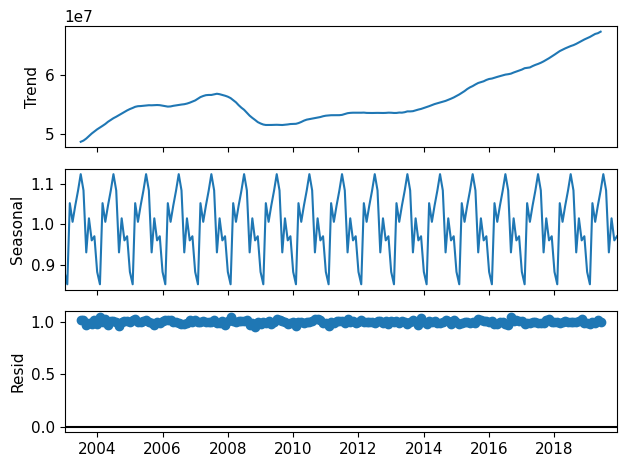

In [ ]:
multiplicative_decomposition = seasonal_decompose(
    df['num_passengers'],
    model='mul',
    period=m
).plot(observed=False)

plt.show()

Как и было указано выше, ***в обоих случаях линия тренда получилась отличной от прямой***. При этом, ***величины ошибок не получились слишком большим***, что говорит о наличии здравого зерна в разложении на сезонность и тренд.

Перейдем теперь к обучению **аддитивной и мультипликативной моделей Хольта-Уинтерса**. Сперва попробуем это сделать, не задавая никаких дополнительных параметров

In [ ]:
model_add_auto_1 = ExponentialSmoothing(df['num_passengers'], initialization_method='estimated', trend='add', seasonal="add").fit()
model_mul_auto_1 = ExponentialSmoothing(df['num_passengers'], initialization_method='estimated', trend='mul', seasonal="mul").fit()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


Получили два сообщения о том, что оптимизация не сошлась; попробуем построить улучшенные модели, задав ***общие для обеих моделей начальный уровень*** (*значение числа пассажиров в декабре 2003*) и ***начальный тренд*** (*разность между средним числом перевозок в 2004 и 2003 годах*); ***начальную сезонность для каждой модели*** выразим через *значения в 2003 году и средним в этот же год*.

In [ ]:
vals = df['num_passengers'].values

y0 = vals[m-1] # Начальный уровень
b0 = np.mean(vals[m:2*m]) - np.mean(vals[:m]) # Начальный тренд

seasonality0_add = list(vals[:m] - np.mean(vals[:m])) # Cезонность для аддитивной модели
seasonality0_mul = list(vals[:m] / np.mean(vals[:m])) # Cезонность для мультипликативной модели

Сперва обучим аддитивную модель, *оптимизируя веса встроенным методом*

In [ ]:
model_add = ExponentialSmoothing(df['num_passengers'], trend='add', seasonal="add", initialization_method='known',
                                 initial_level=y0, initial_seasonal=seasonality0_add, initial_trend=b0)

In [ ]:
model_add_auto_2 = model_add.fit(optimized=True)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


Снова оптимизации не удалось успешно сойтись, то есть полученные веса вновь могут не являться оптимальными. Попробуем обучить модель *путем прямой минимизации функционала ошибки*

In [ ]:
def mse_additive(y, alpha, beta, gamma, m):
  prediction = model_add.fit(smoothing_level=alpha, smoothing_trend=beta, smoothing_seasonal=gamma, optimized=False)
  return mse(df['num_passengers'], prediction.fittedvalues)

In [ ]:
bnds = ((0,1), (0,1), (0,1))

model_add_extr = minimize(lambda x: mse_additive(df['num_passengers'].values, x[0], x[1], x[2], 12), x0=np.zeros(3), bounds=bnds)

model_add_extr

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 2824772774774.118
        x: [ 9.000e-01  1.080e-01  1.579e-01]
      nit: 18
      jac: [-3.076e+06  6.055e+06  6.787e+06]
     nfev: 104
     njev: 26
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>

Сопоставим полученные модели с самой первой, сравнив разность между функциями потерь

In [ ]:
print(mse(df['num_passengers'], model_add_auto_1.fittedvalues) - mse(df['num_passengers'], model_add_auto_2.fittedvalues))
print(mse(df['num_passengers'], model_add_auto_1.fittedvalues) - model_add_extr.fun)

-1599684060960.7942
-1583197239828.2703


Получилось, что ***обе попытки получить лучший результат вышли достаточно бесполезными***; поэтому, **в качестве наилучшей модели выберем полностью автоматизированный вариант**. *Сделаем предсказания на 3 года и отрисуем все на графике* (вместе с кривой исходных данных)

In [ ]:
predicted_add = model_add_auto_1.predict(start=df.index[-1] + pd.DateOffset(month=1), end=df.index[-1] + pd.DateOffset(month=1) + pd.DateOffset(years=3))

<ipython-input-113-d310fff37093>:2: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  plt.plot(model_add_auto_1.fittedvalues.append(predicted_add).values, label="Аддитивная аппроксимация и прогноз по методу Хольта-Уинтерса", color='green')


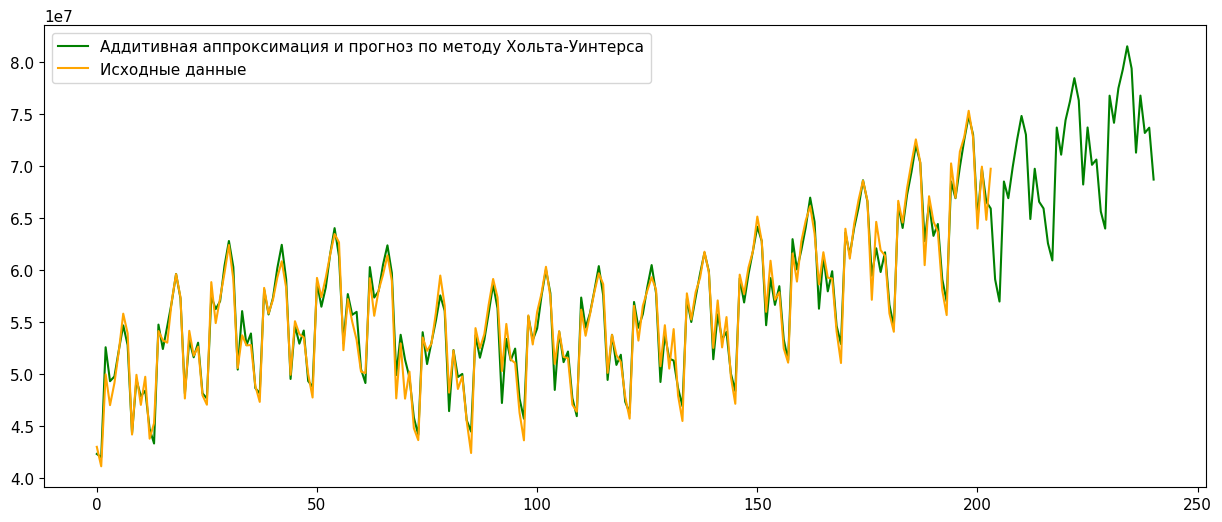

In [ ]:
plt.figure(figsize=(15,6))
plt.plot(model_add_auto_1.fittedvalues.append(predicted_add).values, label="Аддитивная аппроксимация и прогноз по методу Хольта-Уинтерса", color='green')
plt.plot(df.values, label="Исходные данные", color='orange')
plt.legend()

plt.show()

Видно, что полученная модель **достаточно посредственно аппроксимирует исходный временной ряд**; особенно ярко это прослеживается ***на промежуточных пиках, поведение которых модель плохо улавливает***

Попробуем теперь улучшить мультипликативную модель

In [ ]:
model_mul = ExponentialSmoothing(df['num_passengers'], trend='mul', seasonal="mul", initialization_method='known',
                                 initial_level=y0, initial_seasonal=seasonality0_mul, initial_trend=b0)

In [ ]:
model_mul_auto_2 = model_mul.fit(optimized=True)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/holtwinters/model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


In [ ]:
print(mse(df['num_passengers'], model_mul_auto_1.fittedvalues) - mse(df['num_passengers'], model_mul_auto_2.fittedvalues))

-3.1558347560797535e+31


Здесь уже получили не только *сообщение о несходимости*, но и *предупреждение о переполнении*; ***mse при этом ухудшился колоссально***; попробуем вновь *напрямую минимизировать функционал ошибки*

In [ ]:
def mse_multiplicative(y, alpha, beta, gamma, m):
  prediction = model_mul.fit(smoothing_level=alpha, smoothing_trend=beta, smoothing_seasonal=gamma, optimized=False)
  return mse(df['num_passengers'], prediction.fittedvalues)

In [ ]:
model_add_extr = minimize(lambda x: mse_multiplicative(df['num_passengers'].values, x[0], x[1], x[2], 12), x0=np.random.rand(3), bounds=bnds)

model_add_extr

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/holtwinters/model.py:1343: RuntimeWarning: overflow encountered in divide
  b[i] = (beta * detrend(lvls[i], lvls[i - 1])) + (
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/holtwinters/model.py:1346: RuntimeWarning: divide by zero encountered in scalar divide
  s[i + m - 1] = y_gamma[i - 1] / trended(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/holtwinters/model.py:1340: RuntimeWarning: invalid value encountered in scalar multiply
  alphac * trended(lvls[i - 1], dampen(b[i - 1], phi))
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/holtwinters/model.py:1344: RuntimeWarning: invalid value encountered in scalar multiply
  betac * dampen(b[i - 1], phi)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/holtwinters/model.py:1348: RuntimeWarning: invalid value encountered in scalar multiply
  ) + (gammac * s[i - 1])
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/holtwinters/model.py:1339: Runt

  message: ABNORMAL_TERMINATION_IN_LNSRCH
  success: False
   status: 2
      fun: nan
        x: [ 6.983e-01  8.958e-01  6.247e-02]
      nit: 0
      jac: [-3.475e+109 -2.283e+109 -1.273e+107]
     nfev: 8
     njev: 2
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>

Получили целое *полотно ошибок*, *связанное с переполнениями при вычислениях*; сама *минимизация же закончилась сразу и неуспешно*. Следовательно и в этом случае ***попытки улучшения обернулись неудачей***, а значит придется использовать **полностью автоматизированный вариант**; вновь *сделаем предсказание и отрисуем все на графике вместе с исходными данными*

In [ ]:
predicted_mul = model_mul_auto_1.predict(start=df.index[-1] + pd.DateOffset(month=1), end=df.index[-1] + pd.DateOffset(month=1) + pd.DateOffset(years=3))

<ipython-input-112-d910182f4dd5>:2: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  plt.plot(model_mul_auto_1.fittedvalues.append(predicted_mul).values, label="Мультипликативная аппроксимация и прогноз по методу Хольта-Уинтерса", color='m')


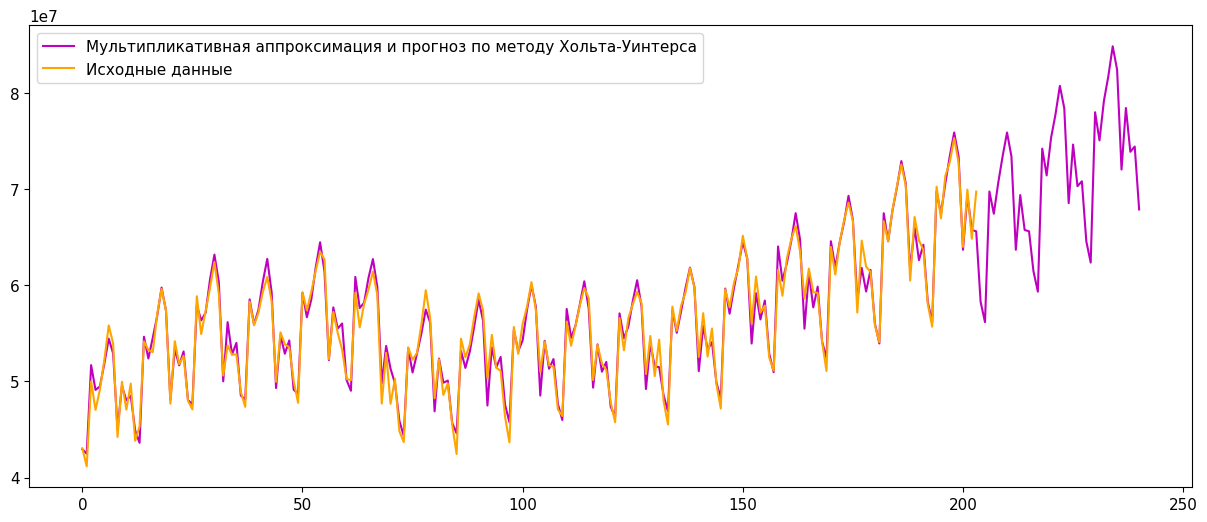

In [ ]:
plt.figure(figsize=(15,6))
plt.plot(model_mul_auto_1.fittedvalues.append(predicted_mul).values, label="Мультипликативная аппроксимация и прогноз по методу Хольта-Уинтерса", color='m')
plt.plot(df.values, label="Исходные данные", color='orange')
plt.legend()

plt.show()

В целом у модели прослеживаются те же проблемы, что и у аддитивной

Остается лишь сравнить две наилучших модели между собой. Для начала *взглянем на их значения mse и разность между ними*

In [ ]:
mse_add = mse(df['num_passengers'], model_add_auto_1.fittedvalues)
mse_mul = mse(df['num_passengers'], model_mul_auto_1.fittedvalues)

print(' MSE additive model: {:.0f}\n'.format(mse_add), 'MSE multiplicative model: {:.0f}\n'.format(mse_mul),
      'MSE difference (add - mul): {:.0f}'.format(mse_add - mse_mul))

 MSE additive model: 1241575534946
 MSE multiplicative model: 1259711578009
 MSE difference (add - mul): -18136043063


Как можно увидеть, аддитивная модель *дает меньшее значение функционала потерь*; тем не менее, это ***различие примерно в 100 раз меньше значений функционалов***, так что можно говорить о **схожести этих моделей в целом**. Схожесть полученных моделей *подтверждается и визуально*, разве что ***мультипликативная в большей степени экстраполирует пиковые значения при предсказании*** (то есть на графике они с течением времени будут все более отличаться от предсказаний аддитивной)

<ipython-input-111-f3c27b85c58e>:2: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  plt.plot(model_add_auto_1.fittedvalues.append(predicted_add).values, label="Аддитивная аппроксимация и прогноз по методу Хольта-Уинтерса", color='green')
<ipython-input-111-f3c27b85c58e>:3: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  plt.plot(model_mul_auto_1.fittedvalues.append(predicted_mul).values, label="Мультипликативная аппроксимация и прогноз по методу Хольта-Уинтерса", color='m')


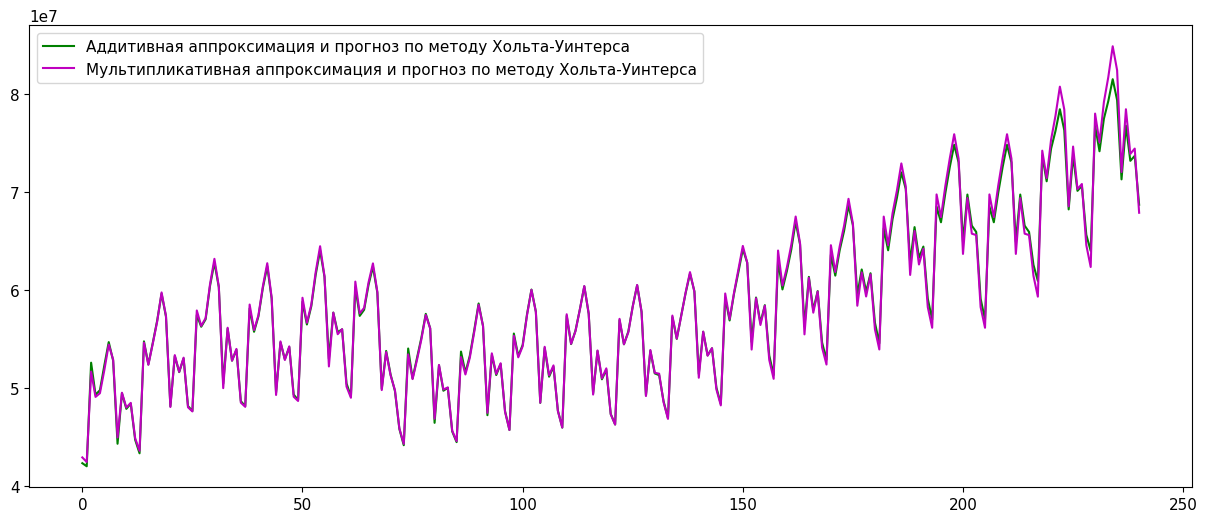

In [ ]:
plt.figure(figsize=(15,6))
plt.plot(model_add_auto_1.fittedvalues.append(predicted_add).values, label="Аддитивная аппроксимация и прогноз по методу Хольта-Уинтерса", color='green')
plt.plot(model_mul_auto_1.fittedvalues.append(predicted_mul).values, label="Мультипликативная аппроксимация и прогноз по методу Хольта-Уинтерса", color='m')
plt.legend()

plt.show()